# pyArgus

## Demonstation and documentation for the direction arrival estimation algorithms

License: GPLv3

Version: 1.1

Author: Tamás Pető

In [2]:
from pyargus.directionEstimation import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In this Ipython notebook the usage and operation of the pyArgus direction of arrival estimation algorithms is presented. For the first demonstration lets simulate a single signal received by a quad element linear antenna array. Let the interelement spacing of the antenna elements half-wavelength $d=0.5 \lambda$

In [5]:
d = 0.5 # Inter element spacing [lambda]
M = 4  # number of antenna elements in the antenna system (ULA)
N = 2**12  # sample size used for the simulation          
theta = 60 # incident angle of the test signal [deg]
    
# Array response vectors of the test signal
a = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta)))

We can check the array response vector with setting specific incident angles. 
- When the signal is received from the front, there should be no phase difference between between the individual received channels. Corresspondingly 
$\textbf{a}(\theta=90^\circ) = \begin{bmatrix}1 & 1 & \dots & 1 \end{bmatrix}$. 
- When the signal is received from the side, there is maximum phase difference. $\textbf{a}(\theta=0^\circ) = \begin{bmatrix}1 & -1 & 1 & -1 \end{bmatrix}$.
- With interelement spacing of half-wavelength, there is $90^\circ$ phase shift between the received signal channels when the incident angle of the signal is $60^\circ$. $\textbf{a}(\theta=60^\circ) = \begin{bmatrix}1 & j & -1 & -j \end{bmatrix}$.


In [6]:
a_90 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(90)))
a_0 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(0)))
a_60 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(60)))

# To display only the first fractional digit
np.set_printoptions(precision=1) 

print("Signal is received from the front: a=",a_90)
print("Signal is received from the side: a=",a_0)
print("Signal is received on 60 deg: a=",a_60)

Signal is received from the front: a= [1.+0.0e+00j 1.+1.9e-16j 1.+3.8e-16j 1.+5.8e-16j]
Signal is received from the side: a= [ 1.+0.0e+00j -1.+1.2e-16j  1.-2.4e-16j -1.+3.7e-16j]
Signal is received on 60 deg: a= [ 1.0e+00+0.0e+00j -3.8e-16+1.0e+00j -1.0e+00-7.7e-16j  7.0e-16-1.0e+00j]


Then we can generate the 4 channel received signal by the following code:

In [8]:
# Array response vectors of the test signal
a = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta)))

# Generate multichannel test signal 
soi = np.random.normal(0,1,N)  # Signal of Interest
soi_matrix  = np.outer( soi, a).T 

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal = soi_matrix + noise 

Now, the received signal array is an $M \times N$ matrix, where $M$ is the number of antenna elements, and $N$ is the sample size. Note that both the signal and the noise has Gaussian distribution in this simulation.

As all the implemented DOA algorithm require the knowledge of the spatial correlation matrix, the calulcation is of this matrix is implemented in a separate function, called "corr_matrix_estimate()". 
$$ R = \frac{1}{N} \sum_{n=0}^{N-1}\textbf{x}_{rec}[n] \textbf{x}_{rec}[n]^H ,$$

where $\textbf{x}_{rec}[n]$ is the $n$th sample of the received multichannel signal.


In [9]:
R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")

In order to call the DOA estimation methods, we must prepare the so called scanning vectors. These vectors store the expected phase relations for the specific incident angles.
We have seen previously that for Uniform Linear Antenna arrays (ULA) the m-th coordinate of this response vector can be generated with the following term:
$$ a(\theta)_m = e^{ j m \beta d cos(\theta)} , \forall m=0 \dots M-1$$
We can generate this vector by using the "gen_ula_scanning_vectors()" function of the pyArgus package. This function has two parameters. The first parameter describes the geometrical alignment of the antenna elements. For linear antenna array it has the following form:
$$\begin{bmatrix} d & 2d & 3d & \dots & (M-1)d \end{bmatrix},$$
where $d$ is the antenna spacing, mesured in the wavelength. The second parameter specfies the expected incident angle.


In [10]:
array_alignment = np.arange(0, M, 1)* d
incident_angles= np.arange(0,181,1)
ula_scanning_vectors = gen_ula_scanning_vectors(array_alignment, incident_angles)

To generate the scanning vectors for circular antenna arrays the "gen_uca_scanning_vectors()" function is available.
For more general antenna array alignments the "gen_scanning_vectors()" function provides the opportunity to generate the required vector array. This function requires the specification of the 'x' and 'y' coordinates of the individual antenna elements. You can see the usage of this function later in the notebook.

After these we can call the desired DOA estimation method. The most simple technique is the Bartlett method:


In [11]:
Bartlett = DOA_Bartlett(R,ula_scanning_vectors)

You can use the DOA results for further processing or you can plot the results with the DOA plot function of the module.


Minimum alias angle 0.00 
Maximum alias angle 0.00 


<Axes: title={'center': 'Direction of Arrival estimation '}, xlabel='Incident angle [deg]', ylabel='Amplitude [dB]'>

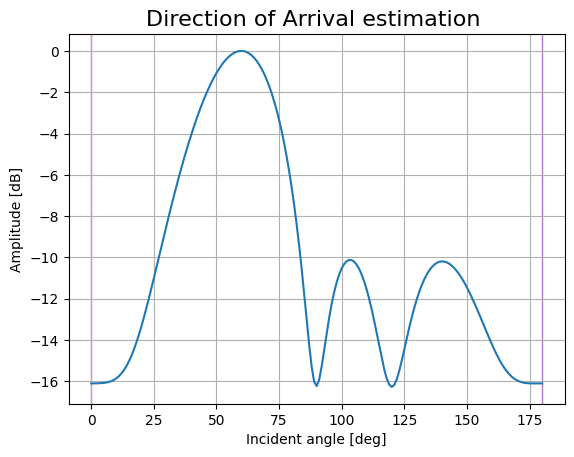

In [12]:
DOA_plot(Bartlett, incident_angles, log_scale_min = -50)

When the interelement spacing is greather than half-wavelength, spatial alliassing occurs. The DOA_plot function is able to highlight the aliasing regions. The following code illustrates this operation.

Minimum alias angle 51.32 
Maximum alias angle 75.52 


<Axes: title={'center': 'Direction of Arrival estimation '}, xlabel='Incident angle [deg]', ylabel='Amplitude [dB]'>

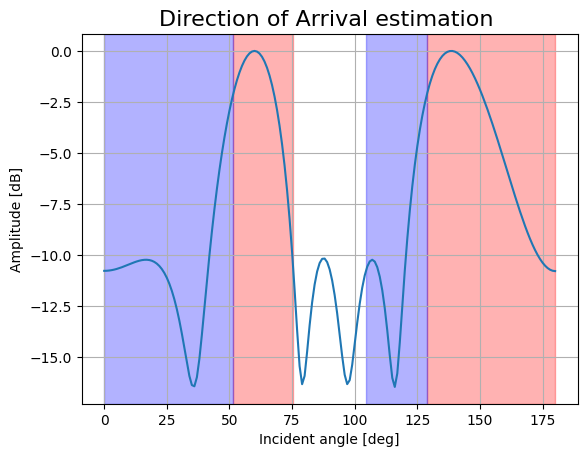

In [16]:
# Change the interelement sapcing. 
# ! Spatial aliasing will occur !
d= 0.8

# Generate scanning vectors with the general purpose function
x = np.arange(0, M, 1) * d  # x coordinates 
y = np.zeros(M) # y coordinates
scanning_vectors = gen_scanning_vectors(M, x, y, incident_angles)

# Array response vector of the test signal
a = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta)))

# Generate multichannel test signal 
soi = np.random.normal(0,1,N)  # Signal of Interest
soi_matrix  = np.outer( soi, a).T 

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal = soi_matrix + noise 

# Estimating the spatial correlation matrix
R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")

# Estimate DOA with the Bartlett method
Bartlett = DOA_Bartlett(R, scanning_vectors)

DOA_plot(Bartlett, incident_angles, log_scale_min = -50, alias_highlight=True, d=d)

With specifying a matplotlib axes object to the DOA_Plot function we can plot multiple DOA results on the sample figure.

Minimum alias angle 51.32 
Maximum alias angle 75.52 


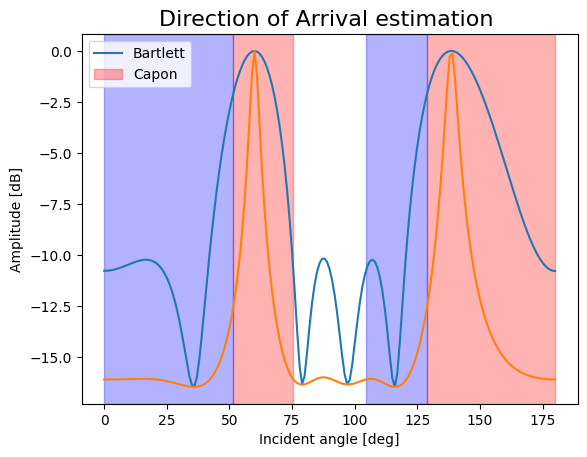

In [17]:
# Get matplotlib axes object
axes = plt.axes()

# Estimate DOA with the Bartlett method
Bartlett = DOA_Bartlett(R, scanning_vectors)

# Estimate DOA with the Capon method
Capon = DOA_Capon(R, scanning_vectors)

# Plot results on the same fiugre
DOA_plot(Bartlett, incident_angles, log_scale_min = -50, alias_highlight=True, d=d, axes=axes)
DOA_plot(Capon, incident_angles, log_scale_min = -50, alias_highlight=False, d=d, axes=axes)

axes.legend(("Bartlett","Capon"))

The DOA estimation module of the pyArgus package implements the following listf of algorithms:

- Bartlett
- Capon
- MEM (Maximum Entropy Method)
- LPM (Linear Prediction Method)
- MUSIC (Multiple Signal Classification)
- MD-MUSIC (Multi Dimensional - MUSIC)

This test code demonstrates their operation

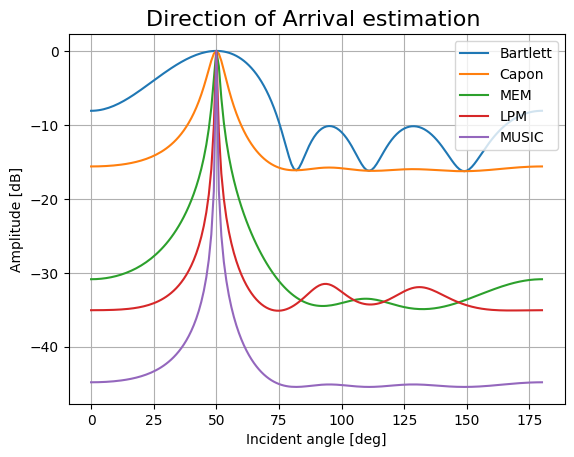

In [18]:
# Interelement spacing is half-wavelength
d= 0.5

# Set angle of incidence
theta =50

# Generate scanning vectors with the general purpose function
x = np.arange(0, M, 1) * d  # x coordinates 
y = np.zeros(M) # y coordinates
scanning_vectors = gen_scanning_vectors(M, x, y, incident_angles)

# Array response vectors of the test signal
a = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta)))

# Generate multichannel test signal 
soi = np.random.normal(0,1,N)  # Signal of Interest
soi_matrix  = np.outer( soi, a).T 

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal = soi_matrix + noise 

# Estimating the spatial correlation matrix
R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")

# Estimate DOA 
Bartlett = DOA_Bartlett(R, scanning_vectors)
Capon = DOA_Capon(R, scanning_vectors)
MEM = DOA_MEM(R, scanning_vectors, column_select = 1)
LPM = DOA_LPM(R, scanning_vectors, element_select = 0)
MUSIC = DOA_MUSIC(R, scanning_vectors, signal_dimension = 1)

# Get matplotlib axes object
axes = plt.axes()

# Plot results on the same fiugre
DOA_plot(Bartlett, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)
DOA_plot(Capon, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)
DOA_plot(MEM, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)
DOA_plot(LPM, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)
DOA_plot(MUSIC, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)

axes.legend(("Bartlett","Capon","MEM","LPM","MUSIC"))


### Implementations for the resolution of coherenet sources

When the received signal matrix contains coherent signal sources, the traditional DOA estimation methods are likely to fail. This is demonstrated via the the following code.


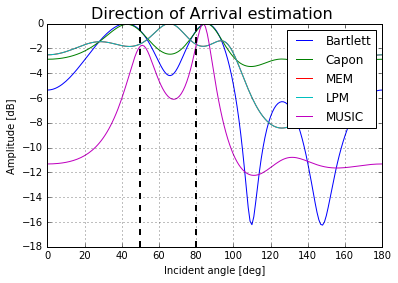

In [12]:
# Interelement spacing is half-wavelength
d= 0.5

# Incident angle of source 1
theta_1 =50

# Incident angle of source 2
theta_2 =80

# Generate ULA scanning vectors
array_alignment = np.arange(0, M, 1)* d
incident_angles= np.arange(0,181,1)
scanning_vectors = gen_ula_scanning_vectors(array_alignment, incident_angles)

# Array response vectors of test source 1
a_1 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta_1)))

# Array response vectors of test source 2
a_2 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta_2)))

# Generate multichannel test signal 
soi = np.random.normal(0,1,N)  # Signal of Interest
soi_matrix  = ( np.outer( soi, a_1) + np.outer( soi, a_2)).T 

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal = soi_matrix + noise 

# Estimating the spatial correlation matrix
R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")

# Estimate DOA 
Bartlett = DOA_Bartlett(R, scanning_vectors)
Capon = DOA_Capon(R, scanning_vectors)
MEM = DOA_MEM(R, scanning_vectors, column_select = 1)
LPM = DOA_LPM(R, scanning_vectors, element_select = 1)
MUSIC = DOA_MUSIC(R, scanning_vectors, signal_dimension = 2)

# Get matplotlib axes object
axes = plt.axes()

# Plot results on the same fiugre
DOA_plot(Bartlett, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)
DOA_plot(Capon, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)
DOA_plot(MEM, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)
DOA_plot(LPM, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)
DOA_plot(MUSIC, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)

axes.legend(("Bartlett","Capon","MEM","LPM","MUSIC"))

# Mark nominal incident angles
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta_1)
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta_2)

A solution for this problem could be the application of decorrelation techniques. pyArgus implements the forward-backward averaging and the spatial smoothing decorrelation methods. To use the forward-backward averaging replace the original spatial correlation matrix with its forward-backward averaged version.

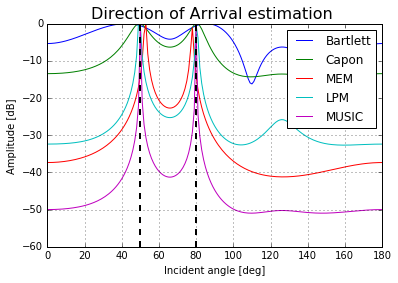

In [13]:
# Caclulate the forward-backward spatial correlation matrix
R_fb = forward_backward_avg(R)

# Estimate DOA using the new spatial correlation matrix
Bartlett = DOA_Bartlett(R_fb, scanning_vectors)
Capon = DOA_Capon(R_fb, scanning_vectors)
MEM = DOA_MEM(R_fb, scanning_vectors, column_select = 1)
LPM = DOA_LPM(R_fb, scanning_vectors, element_select = 0)
MUSIC = DOA_MUSIC(R_fb, scanning_vectors, signal_dimension = 2)

# Get matplotlib axes object
axes = plt.axes()

# Plot results on the same fiugre
DOA_plot(Bartlett, incident_angles, log_scale_min = -60, axes=axes, alias_highlight=False)
DOA_plot(Capon, incident_angles, log_scale_min = -60, axes=axes, alias_highlight=False)
DOA_plot(MEM, incident_angles, log_scale_min = -60, axes=axes, alias_highlight=False)
DOA_plot(LPM, incident_angles, log_scale_min = -60, axes=axes, alias_highlight=False)
DOA_plot(MUSIC, incident_angles, log_scale_min = -60, axes=axes, alias_highlight=False)

axes.legend(("Bartlett","Capon","MEM","LPM","MUSIC"))

# Mark nominal incident angles
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta_1)
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta_2)

The forward-backward averaging technique is only usefull when the received signal contains maximum two coherent sources. The next simulation show this behaviour with considering three coherent sources and 8 antenna elements.

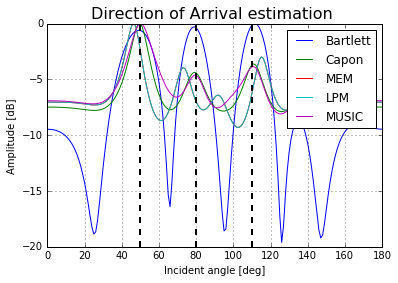

In [14]:
# Number of antenna elements
M = 8

# Interelement spacing is half-wavelength
d= 0.5

# Incident angle of source 1
theta_1 =50

# Incident angle of source 2
theta_2 =80

# Incident angle of source 3
theta_3 = 110

# Generate ULA scanning vectors
array_alignment = np.arange(0, M, 1)* d
incident_angles= np.arange(0,181,1)
scanning_vectors = gen_ula_scanning_vectors(array_alignment, incident_angles)

# Array response vectors of test source 1
a_1 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta_1)))

# Array response vectors of test source 2
a_2 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta_2)))

# Array response vectors of test source 2
a_3 = np.exp(np.arange(0,M,1)*1j*2*np.pi*d*np.cos(np.deg2rad(theta_3)))

# Generate multichannel test signal 
soi = np.random.normal(0,1,N)  # Signal of Interest
soi_matrix  = ( np.outer( soi, a_1) + np.outer( soi, a_2) + np.outer( soi, a_3)).T 

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-1),(M,N))

# Create received signal array
rec_signal = soi_matrix + noise 

# Estimating the spatial correlation matrix
R = corr_matrix_estimate(rec_signal.T, imp="mem_eff")

# Caclulate the forward-backward spatial correlation matrix
R_fb = forward_backward_avg(R)

# Estimate DOA 
Bartlett = DOA_Bartlett(R_fb, scanning_vectors)
Capon = DOA_Capon(R_fb, scanning_vectors)
MEM = DOA_MEM(R_fb, scanning_vectors, column_select = 1)
LPM = DOA_LPM(R_fb, scanning_vectors, element_select = 1)
MUSIC = DOA_MUSIC(R_fb, scanning_vectors, signal_dimension = 3)

# Get matplotlib axes object
axes = plt.axes()

# Plot results on the same fiugre
DOA_plot(Bartlett, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)
DOA_plot(Capon, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)
DOA_plot(MEM, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)
DOA_plot(LPM, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)
DOA_plot(MUSIC, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)

axes.legend(("Bartlett","Capon","MEM","LPM","MUSIC"))

# Mark nominal incident angles
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta_1)
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta_2)
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta_3)

The spatial-smoothing decorraltion technique can resolve even more coherent sources. While using this method the size of the aperture is reduced.

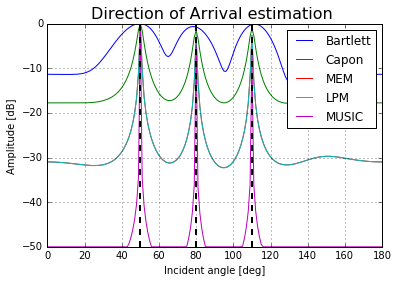

In [15]:
# Sub-array size
P = 7

# Calculate the forward-backward spatially smotthed correlation matrix
R_ss = spatial_smoothing(rec_signal.T, P=P, direction="forward-backward")

# Regenerate the scanning vector for the sub-array
array_alignment = np.arange(0, P, 1)* d
incident_angles= np.arange(0,181,1)
scanning_vectors = gen_ula_scanning_vectors(array_alignment, incident_angles)

# Estimate DOA 
Bartlett = DOA_Bartlett(R_ss, scanning_vectors)
Capon = DOA_Capon(R_ss, scanning_vectors)
MEM = DOA_MEM(R_ss, scanning_vectors, column_select = 1)
LPM = DOA_LPM(R_ss, scanning_vectors, element_select = 1)
MUSIC = DOA_MUSIC(R_ss, scanning_vectors, signal_dimension = 3)

# Get matplotlib axes object
axes = plt.axes()

# Plot results on the same fiugre
DOA_plot(Bartlett, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)
DOA_plot(Capon, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)
DOA_plot(MEM, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)
DOA_plot(LPM, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)
DOA_plot(MUSIC, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)

axes.legend(("Bartlett","Capon","MEM","LPM","MUSIC"))

# Mark nominal incident angles
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta_1)
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta_2)
axes.axvline(linestyle = '--',linewidth = 2,color = 'black',x = theta_3)

### Error handling